In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn import under_sampling , over_sampling
from sklearn.model_selection import train_test_split
from collections import Counter


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv('loan_data.csv')
data.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
"""**Check if data has null values or not**"""
data.isnull().any()

credit.policy        False
purpose              False
int.rate             False
installment          False
log.annual.inc       False
dti                  False
fico                 False
days.with.cr.line    False
revol.bal            False
revol.util           False
inq.last.6mths       False
delinq.2yrs          False
pub.rec              False
not.fully.paid       False
dtype: bool

In [4]:
"""**To get the number of unique values in each column**"""

data.nunique()

credit.policy           2
purpose                 7
int.rate              249
installment          4788
log.annual.inc       1987
dti                  2529
fico                   44
days.with.cr.line    2687
revol.bal            7869
revol.util           1035
inq.last.6mths         28
delinq.2yrs            11
pub.rec                 6
not.fully.paid          2
dtype: int64

In [5]:
data['int.rate'].max()

0.2164

In [6]:
data['installment'].max()

940.14

**Data Visualization**

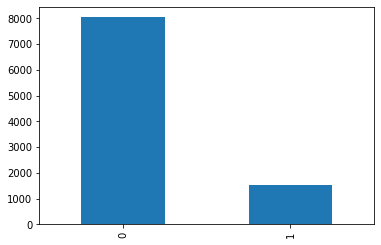

In [7]:
data['not.fully.paid'].value_counts().plot(kind= 'bar')

DATA VISUALIZATION:
1: Over Sampling
2:Under Sampling


In [8]:
data['not.fully.paid'].value_counts()


0    8045
1    1533
Name: not.fully.paid, dtype: int64

In [9]:

zero_percentage = 100 * (data['not.fully.paid'].value_counts()[0]) / len(data)
one_percentage = 100 * (data['not.fully.paid'].value_counts()[1]) / len(data)

print(f'Percentage of zero = {zero_percentage}')
print(f'Percentage of one  = {one_percentage}')


Percentage of zero = 83.99457089162665
Percentage of one  = 16.005429108373356


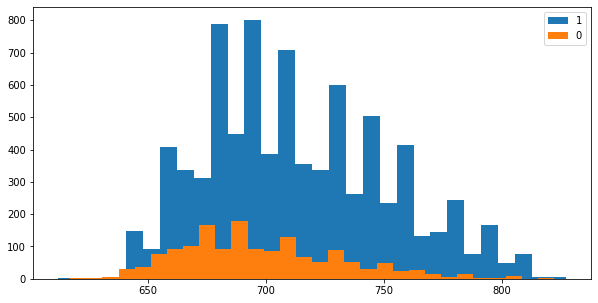

In [11]:
plt.figure(figsize=(10,5))
plt.hist(data[data['not.fully.paid'] == 0]['fico'] , bins = 30 , label="1")
plt.hist(data[data['not.fully.paid'] == 1]['fico'] , bins = 30 , label = "0")
plt.legend(['1','0'])

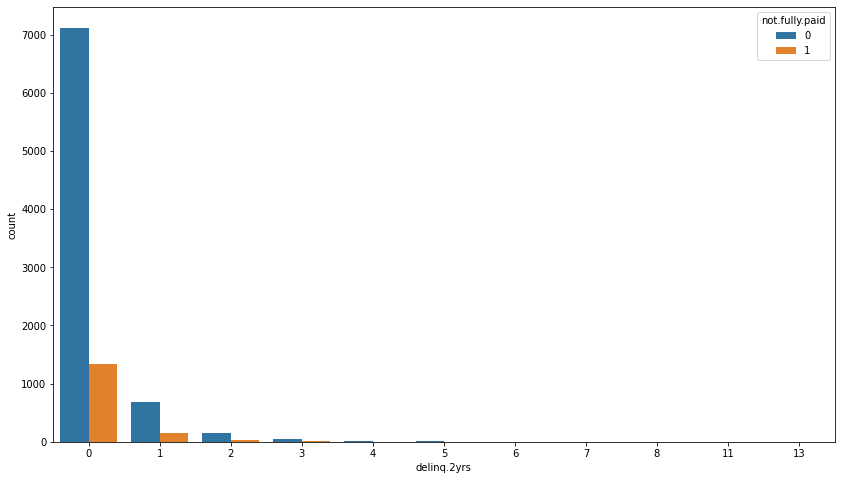

In [12]:
data.corr()['not.fully.paid'].sort_values(ascending = False)

plt.figure(figsize=(14,8))
sns.countplot(data=data, x='delinq.2yrs' ,hue="not.fully.paid")

Under Sampling

In [16]:
datacopy = data
no_frauds = len(datacopy[datacopy['not.fully.paid'] == 1])
non_fraud_indices = datacopy[datacopy["not.fully.paid"] == 0].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = datacopy[datacopy["not.fully.paid"] == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
under_sample = datacopy.loc[under_sample_indices]
print(len(under_sample[under_sample['not.fully.paid'] == 1]))
print(len(under_sample[under_sample['not.fully.paid'] == 0]))

1533
1533


Over Sampling

In [17]:
from imblearn.over_sampling import RandomOverSampler

mydata = data
ros = RandomOverSampler(sampling_strategy=1)
x = mydata.drop('not.fully.paid',axis =1)
y = mydata['not.fully.paid']

x_ros , y_ros = ros.fit_resample(x,y)

targetdata = pd.DataFrame(y_ros,columns=['not.fully.paid'])
x_ros = pd.DataFrame(x_ros,columns=x.columns)
finaldata = pd.concat([x_ros,targetdata],axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:
data_lab = finaldata['not.fully.paid']

data_num = finaldata.drop(['purpose','not.fully.paid'],axis=1)

data_categorical = finaldata[['purpose']]


In [19]:
cat_encoder = OneHotEncoder()
data_cat_hot = cat_encoder.fit_transform(data_categorical)
data_cat_hot.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [21]:
num_pipeline = Pipeline([
    ('std_scaler',StandardScaler())
])
data_num_tr = num_pipeline.fit_transform(data_num)

num_attrs = list(data_num)
cat_attrs = ['purpose']

fullpipeline = ColumnTransformer([
    ('num',num_pipeline,num_attrs),
    ('cat',OneHotEncoder(),cat_attrs)])

data_prepared = fullpipeline.fit_transform(finaldata)

**Classification Model**

In [22]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
X_train, X_test, y_train, y_test = train_test_split(data_prepared,data_lab,test_size = 0.2, random_state = 0)


lin = RandomForestClassifier()
lin.fit(X_train,y_train)
y_pred =lin.predict(X_test)

In [23]:
some_data = data.iloc[:5]
some_data

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [24]:
some_data_prepared = fullpipeline.transform(some_data)

In [25]:
labels = data_lab.iloc[:5]
print("prediction" , lin.predict(some_data_prepared))
print("Some Lables" , list(labels))

prediction [0 0 0 0 0]
Some Lables [0, 0, 0, 0, 0]


In [26]:
from sklearn.model_selection import cross_val_predict

cv = cross_val_predict(lin , X_train , y_train , cv=3)

confusion_matrix(y_train,cv)

print(classification_report(y_test,y_pred))

accuracy_score(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1608
           1       0.97      0.99      0.98      1610

    accuracy                           0.98      3218
   macro avg       0.98      0.98      0.98      3218
weighted avg       0.98      0.98      0.98      3218



0.978247358607831